In [1]:
import pandas as pd
from utils import read_data
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from time import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

# Our task

In this activity, we're asked to "[look] for accident / fatality risk factors, and [provide] an understanding of the factors that contribute to accidents and the severity of accidents." Examples include location, time of day, weather, road surfaces, etc. To answer these questions we are to use road accident and safety data from Great Britain, which can be found [here](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data). We're to create a Jupyter Notebook presenting these findings, communicating these suggested improvements to the Department of Transport. Additionally, if we're able, we are to provide information to car manufacturers to improve their products.

# Modeling strategy

Implicitly, this asks us to create a causal model of the factors leading to an accident or fatality. However, **we lack a plausible exogenous source of variation from which a causal effect could be identified** (for more, [see](https://en.wikipedia.org/wiki/Endogeneity_(econometrics))). For this reason I interpret model results as **correlational, not causal**.

This task is also distinctly different from classical machine learning modeling efforts, where **prediction** is chiefly of interest. **Rather, we are interested in model coefficients** à la regression analysis. 

To satisfy this task, I take a somewhat different approach using a machine learning model ([light gradient boosted machines or LGBM](https://lightgbm.readthedocs.io/en/stable/)) combined with an explanation algorithm, [SHapley Additive exPlanations or SHAP](https://shap.readthedocs.io/en/latest/). 

Compared to traditional regression analysis, where the analyst must a-priori specify the structural causal model, this ML model more flexibly models the outcome variable, enabling it to better align with the population data generating process. SHAP values explain or "credit" the model's prediction to the features included in the model, thereby not only demystifying the traditional "black-box" nature of ML, but also offering an analygous concept to a regression coefficient. Rather than offering a "global" explanation of which features were important to the model as a whole (e.g. XGBoost's `get_scores` method), **SHAP values quantify the effect of features on an individual observation's prediction**, enabling e.g. highly detailed subgroup analysis.

# 1.0 Data

I use data from the most recent three years (2019 - 2021). By including the year 2019, I hope to somewhat offset the irregular traffic and commuting patterns caused by the Corona virus. Older years of data, going back to 1979. are available; however, I prefer to use only newer data in order to examine accident/fatality factors among newer vehicles.

These **data are hierarchical in nature**, presenting some initial modeling and data challenges in their raw form. There are **three distinct entities** and corresponding datasets: **accidents** (i.e. general information where, when, and why), **vehicles** (i.e. cars, vans, buses, trollies, bicycles, and other [horses, farm tractors] involved in an accident), and **casualties** (i.e. within a particular vehicle but also potentially pedestrians struck by a vehicle). Casualties are nested within vehicles, which in turn are nested within accidents. 

### 1.1 Data preprocessing

I use **vehicles as the level of analysis**, aggregating casualty information up to the vehicle level (e.g. total casualties, mean age of casualties, share male) and merge this onto the vehicle file. In a final step, I merge the accident data onto the vehicle file. 

Because substantial data preprocessing was required, I outsourced this several functions in `utils.py`. In addition to data restructuring, I drop several features that I suspect have no causal effect on the outcome, recode unknown category values to missing, engineer some new datetime features, consolidate the number of distinct vehicle types from 22 to 9. 

Importantly, **some vehicles involved in an accident have no casualties** (i.e. they have no match in the casualty dataset), **which I include as a baseline class, "non-injury", in the outcome feature** (see below). This enables me to model the relative risk of this baseline class compared to the other classes. Nonetheless, we lack information about other vehicles near to, but not directly involved, at the time of the accident, which could be considered an alternative "baseline" class.

### 1.2 Outcome feature
**I create a new outcome feature, `casualty_worst`, which represents the worst casualty attributed to a particular vehicle in a particular accident**. Casualties can partain to vehicle occupants or pedestrians struck by the vehicle (bicycles are also counted as vehicles). **This feature does not differentiate between the number of casualties associated with a vehicle**.

This outcome is coded as such:

0) **non-injury*** or slight injury
1) serious injury or fatality

\* New category, created for vehicles in an accident with no casualties

In [2]:
df = read_data()

In [3]:
print(df.casualty_worst.value_counts().sort_index())
print('\n', df.casualty_worst.value_counts(normalize=True).sort_index())

0    500841
1     69332
Name: casualty_worst, dtype: int64

 0    0.878402
1    0.121598
Name: casualty_worst, dtype: float64


### 1.3 EDA 

In [4]:
df.head()

,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,age_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,driver_imd_decile,driver_home_area_type,casualty_class_0,casualty_class_1,casualty_class_2,casualty_class_3,casualty_severity_1,casualty_severity_2,casualty_severity_3,casualty_severity_4,casualty_worst,casualty_share_male,casualty_mean_age,casualty_total,longitude,latitude,number_of_vehicles,local_authority_district,first_road_class,road_type,speed_limit,junction_detail,junction_control,second_road_class,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,datetime,month,day,dayw,hour,elapsed_time
0,2019,010128300,1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,1.0,58.0,NaN,NaN,NaN,2.0,1.0,0,1,2,0,0,0,3,0,0,0.333333,58.0,3,-0.153842,51.508057,2,1.0,3,1.0,30.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0,1,2019-02-18 17:50:00,2,18,0,17,4211040.0
1,2019,010128300,2,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1,0,0,0,0,0,0,1,0,NaN,NaN,1,-0.153842,51.508057,2,1.0,3,1.0,30.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0,1,2019-02-18 17:50:00,2,18,0,17,4211040.0
2,2019,010152270,1,9.0,0.0,18.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,24.0,NaN,NaN,NaN,3.0,1.0,0,1,0,0,0,0,1,0,0,0.000000,24.0,1,-0.127949,51.436208,2,9.0,3,2.0,30.0,0.0,NaN,NaN,4.0,1.0,1.0,0.0,0.0,1,2019-01-15 21:45:00,1,15,1,21,1287540.0
3,2019,010152270,2,9.0,0.0,18.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,1,0,0,0,0,0,0,1,0,NaN,NaN,1,-0.127949,51.436208,2,9.0,3,2.0,30.0,0.0,NaN,NaN,4.0,1.0,1.0,0.0,0.0,1,2019-01-15 21:45:00,1,15,1,21,1287540.0
4,2019,010155191,1,9.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,1.0,45.0,NaN,NaN,NaN,4.0,1.0,1,0,0,0,0,0,0,1,0,NaN,NaN,1,-0.124193,51.526795,2,2.0,4,6.0,30.0,3.0,4.0,6.0,4.0,1.0,1.0,0.0,0.0,1,2019-01-01 01:50:00,1,1,1,1,6240.0


In [5]:
df.shape

(570173, 56)

In [6]:
df['accident_year'].value_counts().sort_index()

2019    216381
2020    167349
2021    186443
Name: accident_year, dtype: int64

In [7]:
df_summary = df.isnull().mean()
df_summary = pd.concat([df_summary, df.dtypes], axis=1)
df_summary.rename(columns={0: 'share_missing', 1: 'dtype'})

,share_missing,dtype
accident_year,0.000000,int64
accident_reference,0.000000,object
vehicle_reference,0.000000,int64
vehicle_type,0.000631,float64
towing_and_articulation,0.024428,float64
vehicle_manoeuvre,0.075167,float64
vehicle_location_restricted_lane,0.072962,float64
junction_location,0.055402,float64
skidding_and_overturning,0.075931,float64
hit_object_in_carriageway,0.074456,float64


# 2.0 ML Model

LightGBM...

### 2.1 Cross-validation split & feature classification

Because our data span the years 2019-2021, this represents a (short) cross-sectional time series. Nonetheless, our cross-validation method ignores this time dimension, pooling all observations and randomly selecting across time. This is acceptable because, without person or vehicle linkages across time, we are forced to assume that our data are independent and identically distributed.

In [8]:
data_config = {
            'categorical_features': [
                    'vehicle_type',
                    'towing_and_articulation',
                    'vehicle_manoeuvre',
                    'junction_location',
                    'skidding_and_overturning',
                    'hit_object_in_carriageway',
                    'vehicle_leaving_carriageway',
                    'hit_object_off_carriageway',
                    'first_point_of_impact',
                    'vehicle_left_hand_drive',
                    'journey_purpose_of_driver',
                    'sex_of_driver',
                    'propulsion_code',
                    'driver_imd_decile',
                    'driver_home_area_type',
                    'local_authority_district',
                    'first_road_class',
                    'road_type',
                    'junction_detail',
                    'junction_control',
                    'second_road_class',
                    'light_conditions',
                    'weather_conditions',
                    'road_surface_conditions',
                    'special_conditions_at_site',
                    'carriageway_hazards',
                    'urban_or_rural_area'
            ],
    
            'numeric_features': [
                    'accident_year',
                    'month',
                    'day',
                    'dayw',
                    'hour',
                    'elapsed_time',
                    'age_of_driver',
                    'engine_capacity_cc',
                    'age_of_vehicle',
                    'casualty_share_male',
                    'casualty_mean_age',
                    'longitude',
                    'latitude',
                    'number_of_vehicles',
                    'speed_limit'
                    ],
    
            'target_feature': 'casualty_worst'
        }

In [9]:
features = data_config['categorical_features'] + data_config['numeric_features']

X_train, X_val, y_train, y_val = train_test_split(df[features], 
                                                    df[data_config['target_feature']],
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=df[data_config['target_feature']],
                                                    shuffle=True)

In [10]:
print(X_train.shape)
print(X_val.shape)

print('\n', y_train.mean())
print(y_val.mean())

(456138, 42)
(114035, 42)

 0.12159916516492816
0.1215942473801903


#### A note on feature normalization

[Feature normalization](https://en.wikipedia.org/wiki/Feature_scaling) (e.g. min-max normalization or z-score standardization) is a common practice for many ML models. Generally, this practice speeds up and stabilizes model training. However, **this data transformation is not required for tree-based models such as the one I'm using**. The reason is because tree-based models do not care about the absolute values of a feature, only the order of the values.

### 2.2 Create LGBM datasets

In [11]:
train = lgb.Dataset(data=X_train, 
                    label=y_train, 
                    categorical_feature=data_config['categorical_features'],
                    free_raw_data=False)

validation = lgb.Dataset(data=X_val, 
                    label=y_val, 
                    categorical_feature=data_config['categorical_features'],
                    free_raw_data=False)

### 2.3 Model hyperparameters

In [12]:
model_config = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    'num_iterations': 100,
    'num_threads': 4,
    'seed': 123,
    'device_type': 'cpu',
    'early_stopping_round': 5,
    'verbose': -1  # set to 2 for full
}

### 2.4 Model training

In [13]:
current = time()

results = {}
bst = lgb.train(model_config, train, valid_sets=[validation], evals_result=results, verbose_eval=False)

print(f"Total model training time: {round(time() - current, 2)} seconds.")

Total model training time: 2.59 seconds.


### 2.5 Model performance at best iteration

Figure 1 depicts the loss function, [binary cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) in the validation set by epoch. We can see the loss continue to decrease until training was halted due to early stopping.

In order to understand Figure 2, AUC, it's necessary to first understand the [receiver operator characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). The ROC curve is an evaluation metric for binary classication problems, which plots the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds. Area under the curve (AUC) is a summary measure of the ROC, capturing the area underneath the ROC curve. Figure 2 therefore represents AUC scores in the validation set across epochs.

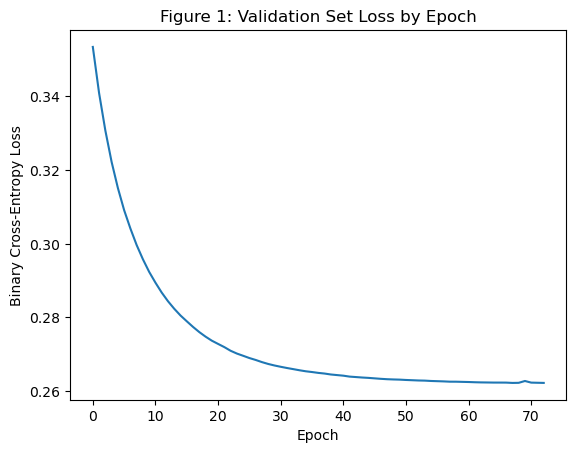

In [14]:
plt.plot(results['valid_0']['binary_logloss'])
plt.title('Figure 1: Validation Set Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.show()

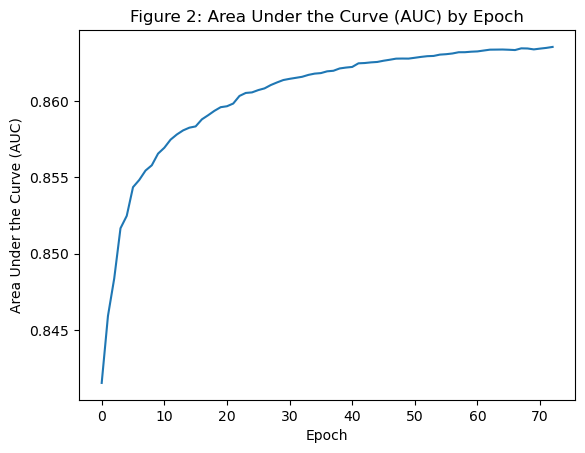

In [15]:
plt.plot(results['valid_0']['auc'])
plt.title('Figure 2: Area Under the Curve (AUC) by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Area Under the Curve (AUC)')
plt.show()